# Multi-Class Image Classification Deep Learning Model for Large Scale Fish Images Using TensorFlow Take 1
### David Lowe
### July 26, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using a TensorFlow convolutional neural network (CNN) and document the end-to-end steps using a template. TheLarge Scale Fish Images dataset is a multi-class classification situation where we attempt to predict one of several (more than two) possible outcomes. For each class, there are 1000 augmented images and their pair-wise augmented ground truths.

INTRODUCTION: This dataset contains nine different seafood types collected from a supermarket in Izmir, Turkey, for a university-industry collaboration project at Izmir University of Economics, and this work was published in ASYU 2020. 

In this Take1 iteration, we will construct a CNN model based on the InceptionV3 architecture to predict the leaf's health state based on the available images.

ANALYSIS: In this Take1 iteration, the InceptionV3 model's performance achieved an accuracy score of 99.65% after five epochs using the training dataset. The same model processed the validation dataset with an accuracy score of 93.83%.

CONCLUSION: In this iteration, the InceptionV3-based CNN model appeared to be suitable for modeling this dataset. We should consider experimenting with TensorFlow for further modeling.

Dataset Used: A Large-Scale Dataset for Fish Segmentation and Classification

Dataset ML Model: Multi-class image classification with numerical attributes

Dataset Reference: Ulucan, Oguzhan and Karakaya, Diclehan and Turkan, Mehmet (2020), "A Large-Scale Dataset for Fish Segmentation and Classification," 2020 Innovations in Intelligent Systems and Applications Conference (ASYU), IEEE (https://ieeexplore.ieee.org/abstract/document/9259867)

One potential source of performance benchmarks: https://www.kaggle.com/crowww/a-large-scale-fish-dataset

A deep-learning image classification project generally can be broken down into five major tasks:

1. Prepare Environment
2. Load and Prepare Images
3. Define and Train Models
4. Evaluate and Optimize Models
5. Finalize Model and Make Predictions

# Task 1 - Prepare Environment

In [1]:
# Install the packages to support accessing environment variable and SQL databases
# !pip install python-dotenv PyMySQL boto3

In [2]:
# Retrieve GPU configuration information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Thu Jul 22 01:00:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve memory configuration information from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [4]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


## 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [6]:
# Load libraries and packages
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
from datetime import datetime
import zipfile
import h5py
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

## 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
VAL_SET_RATIO = 0.2
# TEST_SET_RATIO = 0.5

# Set various default modeling parameters
DEFAULT_LOSS = 'categorical_crossentropy'
DEFAULT_METRICS = ['accuracy']
DEFAULT_OPTIMIZER = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
DEFAULT_INITIALIZER = tf.keras.initializers.RandomNormal(seed=RNG_SEED)
CLASSIFIER_ACTIVATION = 'softmax'
MAX_EPOCHS = 10
BATCH_SIZE = 32
# RAW_IMAGE_SIZE = (100, 100)
TARGET_IMAGE_SIZE = (299, 299)
INPUT_IMAGE_SHAPE = (TARGET_IMAGE_SIZE[0], TARGET_IMAGE_SIZE[1], 3)

NUM_CLASSES = 9
CLASS_LABELS = ['Black_Sea_Sprat',
                'Gilt-Head_Bream',
                'Hourse_Mackerel',
                'Red_Mullet',
                'Red_Sea_Bream',
                'Sea_Bass',
                'Shrimp',
                'Striped_Red_Mullet',
                'Trout']
# CLASS_NAMES = []

# Define the labels to use for graphing the data
train_metric = "accuracy"
validation_metric = "val_accuracy"
train_loss = "loss"
validation_loss = "val_loss"

# Define the directory locations and file names
STAGING_DIR = 'staging/'
TRAIN_DIR = 'staging/archive_augmented/Fish_Dataset/'
# VALID_DIR = ''
# TEST_DIR = ''
# TRAIN_DATASET = ''
# VALID_DATASET = ''
# TEST_DATASET = ''
# TRAIN_LABELS = ''
# VALID_LABELS = ''
# TEST_LABELS = ''
# OUTPUT_DIR = 'staging/'
# SAMPLE_SUBMISSION_CSV = 'sample_submission.csv'
# FINAL_SUBMISSION_CSV = 'submission.csv'

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 1
TensorFlow version: 2.5.0


In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [10]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [11]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 2 - Load and Prepare Images

In [17]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [9]:
!rm -rf staging/
!mkdir staging/
!rm archive_augmented.zip
!wget https://dainesanalytics.com/datasets/kaggle-large-scale-fish-images/archive_augmented.zip

rm: cannot remove 'archive-augmented.zip': No such file or directory
--2021-07-21 22:06:33--  https://dainesanalytics.com/datasets/kaggle-large-scale-fish-images/archive_augmented.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 13.226.52.95, 13.226.52.21, 13.226.52.82, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.226.52.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3127761911 (2.9G) [application/zip]
Saving to: ‘archive_augmented.zip’

archive_augmented.z 100%[===================>]   2.91G  38.9MB/s    in 82s     

2021-07-21 22:07:56 (36.2 MB/s) - ‘archive_augmented.zip’ saved [3127761911/3127761911]



In [11]:
dataset_zip = 'archive_augmented.zip'
zip_ref = zipfile.ZipFile(dataset_zip, 'r')
zip_ref.extractall(STAGING_DIR)
zip_ref.close()

In [31]:
# Brief listing of training image files for each class
for c_label in CLASS_LABELS:
    training_class_dir = os.path.join(TRAIN_DIR, c_label)
    training_class_files = os.listdir(training_class_dir)
    print('Number of training images for', c_label, ':', len(os.listdir(training_class_dir)))
    print('Training samples for', c_label, ':', training_class_files[:5])

Number of training images for Black_Sea_Sprat : 1000
Training samples for Black_Sea_Sprat : ['00448.png', '00098.png', '00165.png', '00021.png', '00689.png']
Number of training images for Gilt-Head_Bream : 1000
Training samples for Gilt-Head_Bream : ['00448.png', '00098.png', '00165.png', '00021.png', '00689.png']
Number of training images for Hourse_Mackerel : 1000
Training samples for Hourse_Mackerel : ['00448.png', '00098.png', '00165.png', '00021.png', '00689.png']
Number of training images for Red_Mullet : 1000
Training samples for Red_Mullet : ['00448.png', '00098.png', '00165.png', '00021.png', '00689.png']
Number of training images for Red_Sea_Bream : 1000
Training samples for Red_Sea_Bream : ['00448.png', '00098.png', '00165.png', '00021.png', '00689.png']
Number of training images for Sea_Bass : 1000
Training samples for Sea_Bass : ['00448.png', '00098.png', '00165.png', '00021.png', '00689.png']
Number of training images for Shrimp : 1000
Training samples for Shrimp : ['0044

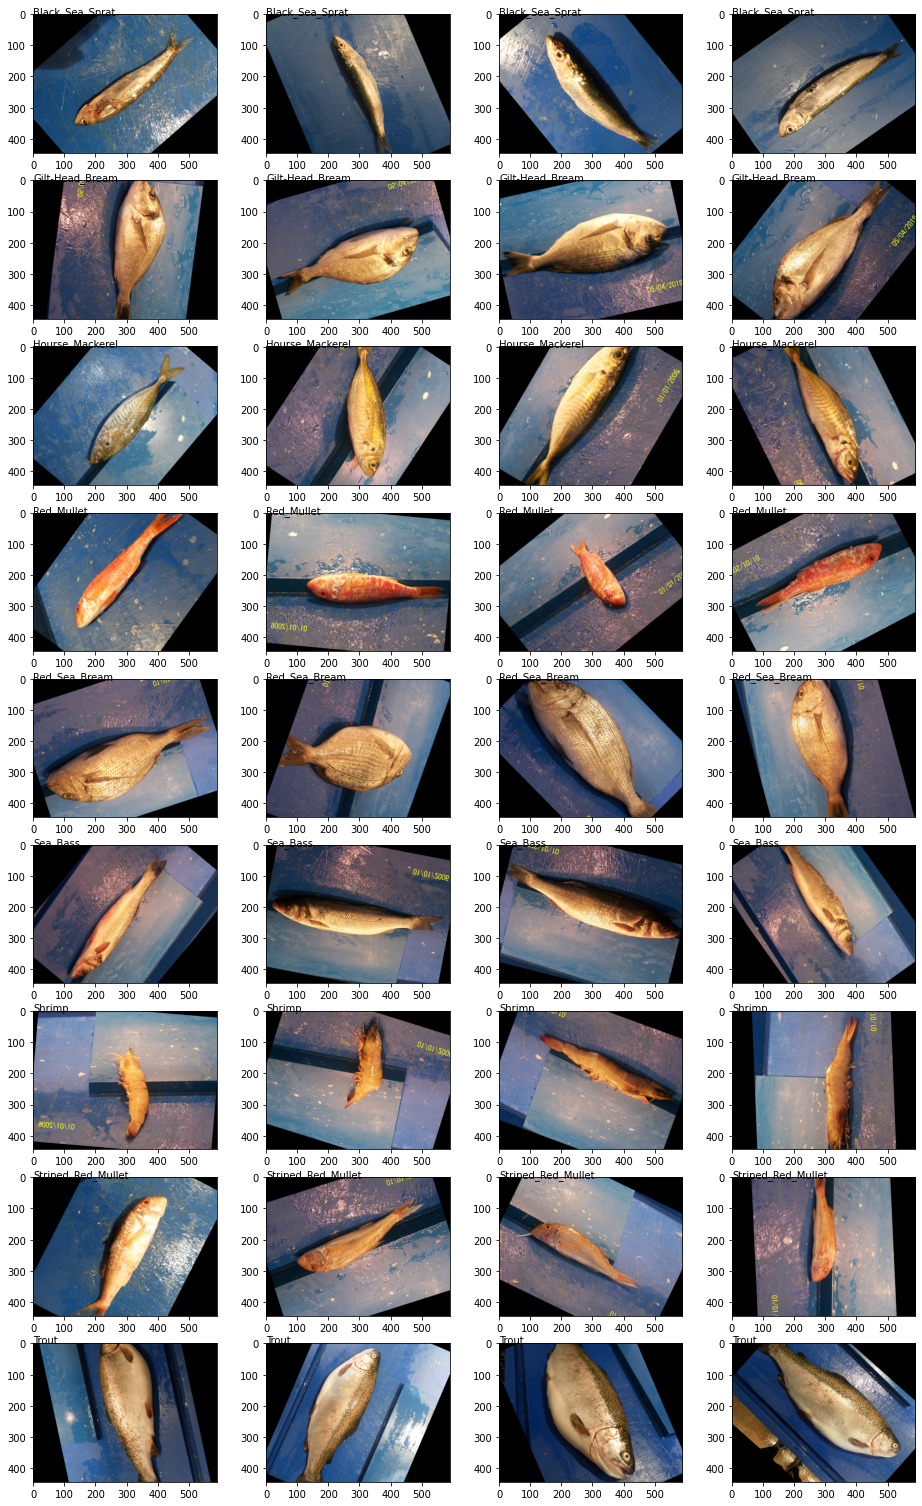

In [33]:
# Plot some training images from the dataset
nrows = NUM_CLASSES
ncols = 4
training_examples = []
example_labels = []

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 3)

for c_label in CLASS_LABELS:
    training_class_dir = os.path.join(TRAIN_DIR, c_label)
    training_class_files = os.listdir(training_class_dir)
    for j in range(ncols):
        training_examples.append(c_label+'/'+training_class_files[j])
        example_labels.append(c_label)
    # print(training_examples)
    # print(example_labels)

for i, img_path in enumerate(training_examples):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i+1)
    sp.text(0, 0, example_labels[i])
    # sp.axis('Off')
    img = mpimg.imread(TRAIN_DIR + img_path)
    plt.imshow(img)
plt.show()

In [22]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 3 - Define and Train Models

In [12]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [13]:
datagen_kwargs = dict(rescale=1./255, validation_split=VAL_SET_RATIO)
training_datagen = ImageDataGenerator(**datagen_kwargs)
validation_datagen = ImageDataGenerator(**datagen_kwargs)
dataflow_kwargs = dict(class_mode="categorical")

do_data_augmentation = False
if do_data_augmentation:
    training_datagen = ImageDataGenerator(rotation_range=90,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          **datagen_kwargs)

print('Loading and pre-processing the training images...')
training_generator = training_datagen.flow_from_directory(directory=TRAIN_DIR,
                                                          target_size=TARGET_IMAGE_SIZE,
                                                          batch_size=BATCH_SIZE,
                                                          shuffle=True,
                                                          seed=RNG_SEED,
                                                          subset="training",
                                                          **dataflow_kwargs)
print('Number of training image batches per epoch of modeling:', len(training_generator))

print('Loading and pre-processing the validation images...')
validation_generator = validation_datagen.flow_from_directory(directory=TRAIN_DIR,
                                                              target_size=TARGET_IMAGE_SIZE,
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=False,
                                                              subset="validation",
                                                              **dataflow_kwargs)
print('Number of validation image batches per epoch of modeling:', len(validation_generator))

Loading and pre-processing the training images...
Found 7200 images belonging to 9 classes.
Number of training image batches per epoch of modeling: 225
Loading and pre-processing the validation images...
Found 1800 images belonging to 9 classes.
Number of validation image batches per epoch of modeling: 57


In [14]:
# Define the function for plotting training results for comparison
def plot_metrics(history):
    fig, axs = plt.subplots(1, 2, figsize=(24, 15))
    metrics =  [train_loss, train_metric]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color='red', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == train_loss:
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0.5, 1.1])
        plt.legend()

In [15]:
# Define the baseline model for benchmarking
def create_nn_model(input_param=INPUT_IMAGE_SHAPE, output_param=NUM_CLASSES, dense_nodes= 1024,
                    init_param=DEFAULT_INITIALIZER, classifier_activation=CLASSIFIER_ACTIVATION,
                    loss_param=DEFAULT_LOSS, opt_param=DEFAULT_OPTIMIZER, metrics_param=DEFAULT_METRICS):
    base_model = keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=input_param)
    nn_model = keras.models.Sequential()
    nn_model.add(base_model)
    nn_model.add(keras.layers.Flatten())
    nn_model.add(keras.layers.Dense(dense_nodes, activation='relu', kernel_initializer=init_param)),
    nn_model.add(keras.layers.Dense(output_param, activation=classifier_activation))
    nn_model.compile(loss=loss_param, optimizer=opt_param, metrics=metrics_param)
    return nn_model

In [16]:
# Initialize the neural network model and get the training results for plotting graph
start_time_module = datetime.now()
# learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
reset_random()
nn_model_0 = create_nn_model()
nn_model_history = nn_model_0.fit(training_generator,
                                  epochs=MAX_EPOCHS,
                                  validation_data=validation_generator,
                                #   callbacks=[learning_rate_reduction],
                                  verbose=1)
print('Total time for model fitting:', (datetime.now() - start_time_module))

Epoch 1/10
225/225 [==============================] - 119s 473ms/step - loss: 1.9197 - accuracy: 0.9061 - val_loss: 7.9361 - val_accuracy: 0.8578
Epoch 2/10
225/225 [==============================] - 104s 460ms/step - loss: 0.3468 - accuracy: 0.9837 - val_loss: 57.1051 - val_accuracy: 0.6072
Epoch 3/10
225/225 [==============================] - 104s 464ms/step - loss: 0.1279 - accuracy: 0.9899 - val_loss: 0.7209 - val_accuracy: 0.9606
Epoch 4/10
225/225 [==============================] - 104s 464ms/step - loss: 0.0417 - accuracy: 0.9947 - val_loss: 0.2334 - val_accuracy: 0.9728
Epoch 5/10
225/225 [==============================] - 103s 456ms/step - loss: 0.2002 - accuracy: 0.9942 - val_loss: 14.0872 - val_accuracy: 0.8456
Epoch 6/10
225/225 [==============================] - 105s 464ms/step - loss: 0.1785 - accuracy: 0.9939 - val_loss: 0.2891 - val_accuracy: 0.9694
Epoch 7/10
225/225 [==============================] - 104s 462ms/step - loss: 0.0572 - accuracy: 0.9944 - val_loss: 0.1650

In [17]:
nn_model_0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              134218752 
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 9225      
Total params: 156,030,761
Trainable params: 155,996,329
Non-trainable params: 34,432
_________________________________________________________________


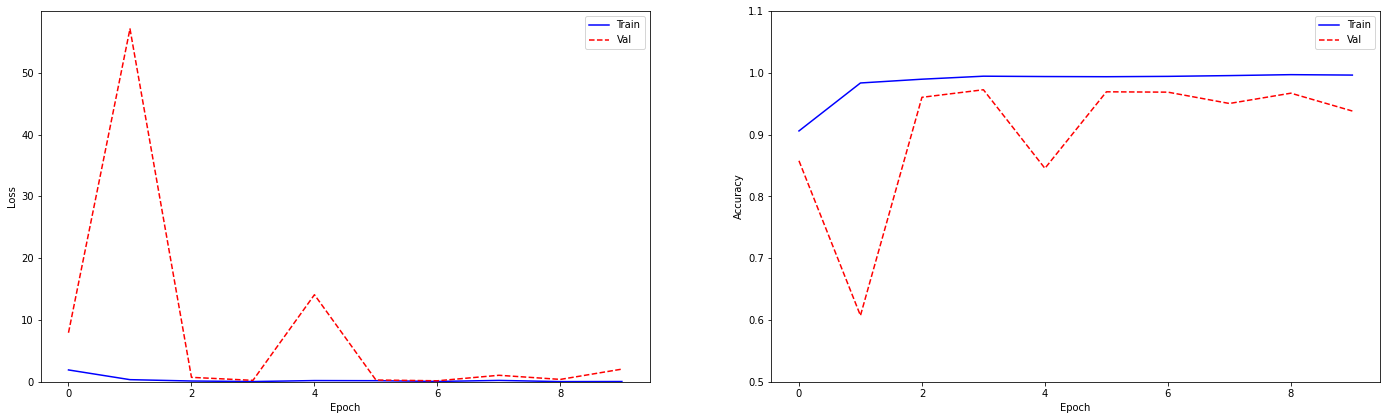

In [18]:
plot_metrics(nn_model_history)

In [19]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 4 - Evaluate and Optimize Models

In [20]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 4 - Evaluate and Optimize Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [21]:
# Not applicable for this iteration of modeling

In [22]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 4 - Evaluate and Optimize Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 5 - Finalize Model and Make Predictions

In [23]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [24]:
# Not applicable for this iteration of modeling

In [25]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [26]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 0:18:26.346943
